In [155]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 200)

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

In [2]:
import palettable

Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# Analyze Gene Set Enrichment Results

My previous notebook, where I generated the results for the gene set enrichment results (`cwas-gene-set-enrichment`), was getting way too long. I'll use this notebook to analyze the results instead.

There are a _ton_ of results here. We'll need to be careful in parsing through these.

# Load in our data

We have to load in all our appropriate data, including SVs and the gene set enrichment results. We copy the same process as detailed in `cwas-gene-set-enrichment`

In [3]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

Load metadata and SVs

In [4]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)

for disease in ["neuroblastoma", "ewing"]:
    for cohort in ["case", "control"]:
        samples[disease][cohort] = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()
        print(disease, cohort, len(samples[disease][cohort]))

neuroblastoma case 688
neuroblastoma control 4831
ewing case 775
ewing control 4574


We don't need the SVs for now, but leaving this in for future reference.

In [5]:
# ###############
# ##### SVs #####
# ###############
# svs = pd.read_csv(sv_path, sep="\t", usecols=range(49))

# ###############
# ### Dosages ###
# ###############=

# # we only need the dosages of our samples in question
# dosage_head = pd.read_csv(dosages_path, sep="\t", index_col=False, nrows=1)

# cols = [3] + [i for i, c in enumerate(dosage_head.columns) if c in total_samples]

# dosages = pd.read_csv(dosages_path, sep="\t", index_col=False, usecols=cols)

# dosages = dosages.set_index("ID")

## Read in category genes

These are the genes that are eligible for each category.

In [6]:
category_gene_matrix = pd.read_csv(
    "data/cwas-results/category-gene-matrix.csv"
).set_index("category")

In [7]:
category_gene_matrix.iloc[:10, :50]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS1,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,ABCB4,ABCB5,ABCB6,ABCB7,ABCB8
category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DEL.SINGLETON.ANY.unconstrained.expressed_in_adrenal_gland.protein_coding,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1
DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1
DEL.SINGLETON.ANY.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_COPY_GAIN.ANY.expressed_in_adrenal_gland.protein_coding,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_COPY_GAIN.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_INTRAGENIC_EXON_DUP.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_adrenal_gland.protein_coding,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
CPX_or_INV.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.ANY.protein_coding,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
gene_ref = list(category_gene_matrix.columns)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [177]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding


In [10]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

We add a metric for whether the category is significant after bonferroni, based on a message for Riaz giving us a cutoff

In [45]:
p_val_cutoffs = {
    "neuroblastoma-coding": 0.05 / 279,
    "neuroblastoma-noncoding": 0.05 / 940,
    "ewing-coding": 0.05 / 267,
    "ewing-noncoding": 0.05 / 916,
}

In [46]:
framework_results["bonferroni_significant"] = framework_results.apply(
    lambda row: row["p_value"]
    < p_val_cutoffs[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

In [47]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category,bonferroni_significant
0,0.332482,0.089278,3.724134,0.000196,148,3,513,646,800,3,3982,4699,1259,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,DEL,SINGLETON,0.229102,0.170249,0.177362,3.707772,neuroblastoma,coding,singleton,False
1,0.282519,0.082899,3.407985,0.000654,170,3,501,646,935,3,3870,4699,1512,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,DEL,SINGLETON,0.263158,0.198979,0.206735,3.184126,neuroblastoma,coding,singleton,False


In [48]:
framework_results.query("bonferroni_significant").shape

(44, 24)

In [49]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## Shrink down our data

We subset some of our data to prevent working with massive matrices.

In [16]:
# shrink down our categories to only those that are significant
framework_results = framework_results.query("negative_log10_p_value > 3.0").reset_index(
    drop=True
)

# # subset our SVs to these categories. Have to be careful about disease, since category names can repeat.
# included_disease_categories = (framework_results['disease'] + '-' + framework_results['category_name']).tolist()

# # subset down category svs to these categories
# category_svs = category_svs[(category_svs['disease'] + '-' + category_svs['category']).isin(included_disease_categories)].reset_index(drop = True)

# # drop SVs down to these SVs
# svs = svs[svs['name'].isin(set(category_svs['SV']))]

# # shrink dosages down to our nbl samples and these SVs
# full_sample_list = samples['ewing']['case'] + samples['ewing']['control'] + samples['neuroblastoma']['case'] + samples['neuroblastoma']['control']
# dosages = dosages.loc[svs['name'].tolist(), sorted(set(full_sample_list))]

# # shrink down category lookups
# category_gene_matrix = category_gene_matrix.loc[sorted(set(framework_results['category_name']))]

## Read in gene set enrichment results

Read in our GSE results for the categories. This file is _huge_, since we fully enumerated a number of possible analyses.

In [183]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")

In [51]:
gse_results = pd.read_csv(
    "data/cwas-results/cwas-gene-set-enrichment-results-correct.csv"
)
binom_results = pd.read_csv("data/cwas-results/cwas-category-gs-binomial-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]
binom_results = binom_results[
    binom_results["category"].isin(framework_results["category_name"].tolist())
]

# reformat and merge
overlap_cols = ["disease", "category", "sv_category", "db", "gs"]
gse_results.columns = [
    c + "_fisher" if c not in overlap_cols else c for c in gse_results.columns
]
binom_results.columns = [
    c + "_binom" if c not in overlap_cols else c for c in binom_results.columns
]

combined_gse_results = gse_results.merge(binom_results, on=overlap_cols)

In [52]:
# also read in the baseline category results
baseline_gse_results = pd.read_csv(
    "data/cwas-results/category-gene-set-raw-significance.csv"
)[["category", "db", "gs", "expected", "data", "odds_ratio", "p", "fdr_p"]]
baseline_gse_results = baseline_gse_results.drop_duplicates(
    subset=["category", "db", "gs"]
)

# merge again
overlap_cols = ["category", "db", "gs"]
baseline_gse_results.columns = [
    c + "_cat_baseline" if c not in overlap_cols else c
    for c in baseline_gse_results.columns
]
combined_gse_results = combined_gse_results.merge(baseline_gse_results, on=overlap_cols)

In [53]:
combined_gse_results = combined_gse_results[
    ~(combined_gse_results["db"].isin(["custom", "Reactome_2022"]))
]

In [54]:
combined_gse_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,6/1015,1/105,1.61699,0.49894,1.0,24/3149,1/540,0.24157,0.16202,0.77074,2/326,1/63,2.61290,0.41230,1.0,0.00557,0.00885,0.46778,1.0,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,26/2358,1/113,0.80082,1.00000,1.0,200/16821,1/632,0.13170,0.01156,0.15754,2/391,1/65,3.03906,0.37026,1.0,0.00557,0.00885,0.46778,1.0,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246


In [57]:
rename = {'category_name': 'category', 'bonferroni_significant': 'category_bonferroni_significant'}
merge = framework_results[['point_estimate', 'category_name', 'disease', 'bonferroni_significant']].rename(columns = rename)

In [60]:
combined_gse_results = combined_gse_results.merge(merge, on = ['disease', 'category'])

So now we have all our data. It's very complicated.

In [62]:
category_to_expression = {
    c: c.split(".")[4] if len(c.split(".")) == 6 else c.split(".")[6]
    for c in framework_results["category_name"].tolist()
}
category_to_functional = {
    c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
    for c in framework_results["category_name"].tolist()
}

combined_gse_results["expression"] = [category_to_expression[c] for c in combined_gse_results["category"]]
combined_gse_results["functional_category"] = [
    category_to_functional[c] for c in combined_gse_results["category"]
]

Now we read in the gene sets

In [63]:
gene_sets = {}
with open("ref/gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]
        gene_sets[db + " | " + gs] = genes

# Analyze high level category results

To start, we'll examine the category baseline results alone.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


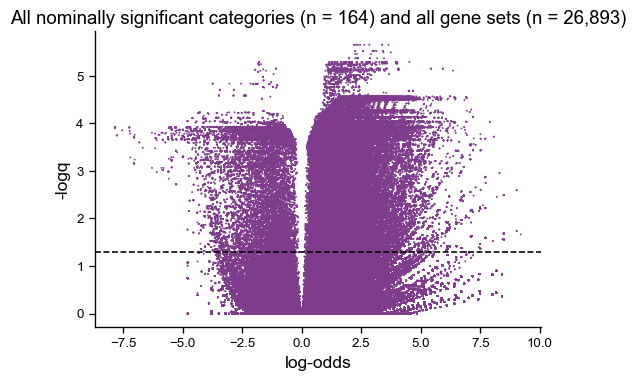

In [24]:
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.scatterplot(
    x=np.log2(combined_gse_results["odds_ratio_cat_baseline"][::2]),
    y=-np.log10(combined_gse_results["fdr_p_cat_baseline"][::2]),
    ec=None,
    s=2,
)
sns.despine(ax=ax)
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black")
ax.set_xlabel("log-odds")
ax.set_ylabel("-logq")
ax.set_title(
    "All nominally significant categories (n = 164) and all gene sets (n = 26,893)"
)
fig.savefig("images/baseline-category-enrichment-all.png", bbox_inches="tight")

## Compare the binary genes vs. full counts

We used two approaches--one that binarized genes impacted by SVs and another that actually used counts. I want to compare these two.

In [25]:
binary = combined_gse_results.iloc[::2, :]
full = combined_gse_results.iloc[1::2, :]

In [26]:
binary.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,6/1015,1/105,1.61699,0.49894,1.0,24/3149,1/540,0.24157,0.16202,0.77074,2/326,1/63,2.6129,0.4123,1.0,0.00557,0.00885,0.46778,1.00000,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246
2,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,Hypoxia,8/1015,1/105,1.21034,0.58906,1.0,25/3149,4/540,0.93254,1.00000,1.00000,2/326,0/63,0.0000,1.0000,1.0,0.00680,0.01770,0.17972,0.87025,1,0.00680,0.00791,0.62608,0.99680,4,0.00680,0.00000,1.00000,1.0,0,200/19092,33/4851,0.577229,0.003174,0.007934


We care about cases, so let's see what happens to the odds-ratios usually

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == "":
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


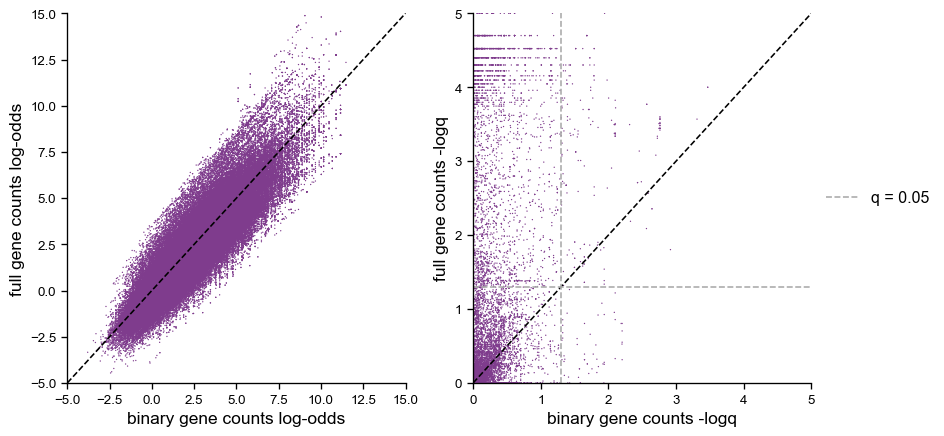

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(["odds_ratio_cases_fisher", "fdr_p_cases_fisher"]):

    ax = axes[i]

    data_binary = binary[col].values
    data_full = full[col].values

    if col == "odds_ratio_cases_fisher":
        data_binary = np.log2(data_binary)
        data_full = np.log2(data_full)
    else:
        data_binary = -np.log10(data_binary)
        data_full = -np.log10(data_full)

    sns.scatterplot(x=data_binary, y=data_full, ec=None, s=1, ax=ax)

    lim = [-5, 15] if col == "odds_ratio_cases_fisher" else [0, 5]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim, lim, linestyle="dashed", color="black")

    label = ["log-odds", "-logq"][i]
    ax.set_xlabel("binary gene counts " + label)
    ax.set_ylabel("full gene counts " + label)
    sns.despine(ax=ax)

    if col == "fdr_p_cases_fisher":
        ax.axhline(
            -np.log10(0.05), color="darkgrey", linestyle="dashed", label="q = 0.05"
        )
        ax.axvline(-np.log10(0.05), color="darkgrey", linestyle="dashed")
        ax.legend(bbox_to_anchor=(1, 0.5))

fig.savefig(
    "images/binary-vs-full-gene-counts-gse-log-odds-logq.png", bbox_inches="tight"
)

So we can see that while the use of full counts doesn't have a _dramatic_ impact on odds-ratio (on average), it has a _substantial_ impact on p-value. This makes sense because full counts give more power.

I've come to the conclusion that should we use one of these, it should just be the full gene counts. But I don't think we actually care about these.

## Compare enrichment based on genomic overlap and SV counts

In [28]:
full.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,26/2358,1/113,0.80082,1.00000,1.0,200/16821,1/632,0.13170,0.01156,0.15754,2/391,1/65,3.03906,0.37026,1.0,0.00557,0.00885,0.46778,1.00000,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246
3,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,full,MSigDB_Hallmark_2020,Hypoxia,30/2358,2/113,1.39820,0.65589,1.0,235/16821,5/632,0.56283,0.29209,0.58628,2/391,0/65,0.00000,1.00000,1.0,0.00680,0.01770,0.17972,0.87025,1,0.00680,0.00791,0.62608,0.99680,4,0.00680,0.00000,1.00000,1.0,0,200/19092,33/4851,0.577229,0.003174,0.007934


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == "":
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  


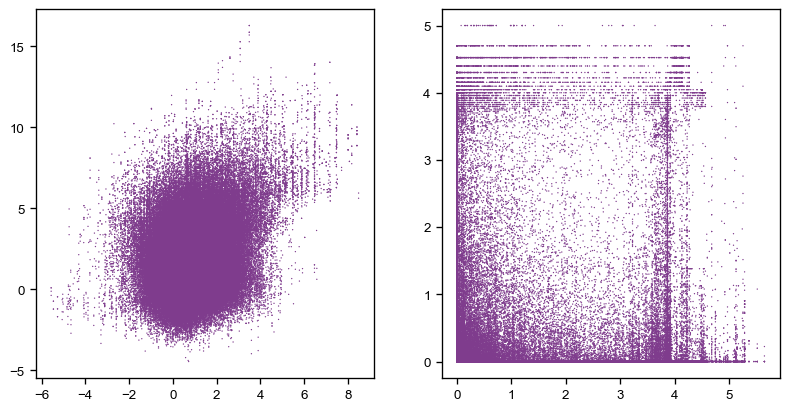

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (count_col, overlap_col) in enumerate(
    [
        ["odds_ratio_cases_fisher", "odds_ratio_cat_baseline"],
        ["fdr_p_cases_fisher", "fdr_p_cat_baseline"],
    ]
):

    ax = axes[i]

    data_overlap = full[overlap_col].values
    data_full = full[count_col].values

    if count_col == "odds_ratio_cases_fisher":
        data_overlap = np.log2(data_overlap)
        data_full = np.log2(data_full)
    else:
        data_overlap = -np.log10(data_overlap)
        data_full = -np.log10(data_full)

    sns.scatterplot(x=data_overlap, y=data_full, ec=None, s=1, ax=ax)

#     lim = [-5, 15] if col == 'odds_ratio_cases_fisher' else [0, 5]
#     ax.set_xlim(lim)
#     ax.set_ylim(lim)
#     ax.plot(lim, lim, linestyle="dashed", color="black")

#     label = ['log-odds', '-logq'][i]
#     ax.set_xlabel("binary gene counts " + label)
#     ax.set_ylabel("full gene counts " + label)
#     sns.despine(ax=ax)

#     if col == 'fdr_p_cases_fisher':
#         ax.axhline(-np.log10(0.05), color = 'darkgrey', linestyle = 'dashed', label = 'q = 0.05')
#         ax.axvline(-np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')
#         ax.legend(bbox_to_anchor = (1, 0.5))

# fig.savefig(
#     "images/binary-vs-full-gene-counts-gse-log-odds-logq.png", bbox_inches="tight"
# )

## Examine category baseline vs. binomial test

This is what I think we _actually_ care about.

In [30]:
combined_gse_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,6/1015,1/105,1.61699,0.49894,1.0,24/3149,1/540,0.24157,0.16202,0.77074,2/326,1/63,2.61290,0.41230,1.0,0.00557,0.00885,0.46778,1.0,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,26/2358,1/113,0.80082,1.00000,1.0,200/16821,1/632,0.13170,0.01156,0.15754,2/391,1/65,3.03906,0.37026,1.0,0.00557,0.00885,0.46778,1.0,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246


In [31]:
combined_gse_results_full = combined_gse_results[
    combined_gse_results["analysis_fisher"] == "full"
]

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


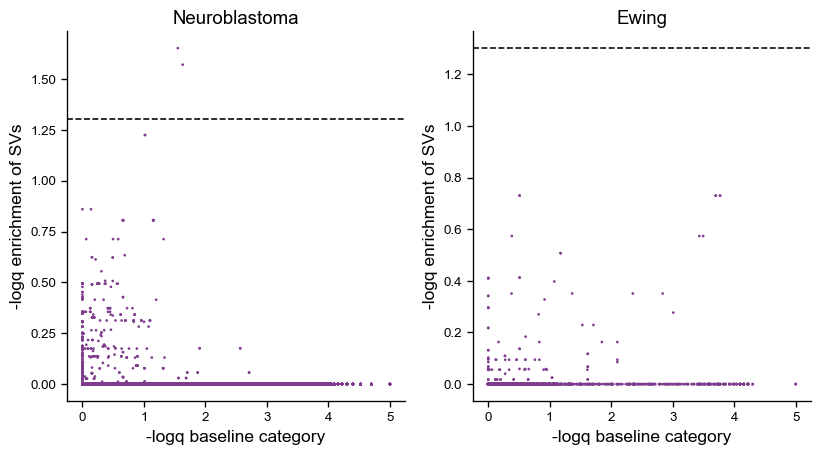

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, disease in enumerate(["neuroblastoma", "ewing"]):

    ax = axes[i]

    sns.scatterplot(
        x=-np.log10(
            combined_gse_results_full.query(f'disease == "{disease}"')[
                "fdr_p_cases_fisher"
            ]
        ),
        y=-np.log10(
            combined_gse_results_full.query(f'disease == "{disease}"')[
                "fdr_p_cases_unique_binom"
            ]
        ),
        ec=None,
        s=4,
        ax=ax,
    )

    sns.despine(ax=ax)
    ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black")
    ax.set_xlabel("-logq baseline category")
    ax.set_ylabel("-logq enrichment of SVs")
    ax.set_title(disease.capitalize())
    # fig.savefig("images/baseline-category-enrichment-all.png", bbox_inches="tight")

# Analyze most stringent results

We apply a handful of filters:

* Single gene SVs
* Remove genes in controls for within-category (don’t do this in baseline, because control signal already controlled by examining nominal cats)
* p_controls_binomial > 0.05 (no within-category control enrichment)
* At least two genes affected (for within and baseline)

In [93]:
stringent_results = combined_gse_results[
    combined_gse_results["analysis_fisher"] == "full"
].copy()

# filter out signals in control
stringent_results = stringent_results.query("p_controls_binom > 0.05")

In [90]:
stringent_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,num_unique_genes_in_overlap_case_unique,num_cat_svs_case_unique
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,26/2358,1/113,0.80082,1.00000,1.0,200/16821,1/632,0.13170,0.01156,0.15754,2/391,1/65,3.03906,0.37026,1.0,0.00557,0.00885,0.46778,1.00000,1,0.00557,0.00158,0.27748,0.78846,1,0.00557,0.01538,0.30427,1.0,1,199/19092,27/4851,0.457816,0.000054,0.000246,0.332482,False,ANY,NaN,1,65
3,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,full,MSigDB_Hallmark_2020,Hypoxia,30/2358,2/113,1.39820,0.65589,1.0,235/16821,5/632,0.56283,0.29209,0.58628,2/391,0/65,0.00000,1.00000,1.0,0.00680,0.01770,0.17972,0.87025,1,0.00680,0.00791,0.62608,0.99680,4,0.00680,0.00000,1.00000,1.0,0,200/19092,33/4851,0.577229,0.003174,0.007934,0.332482,False,ANY,NaN,0,65


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


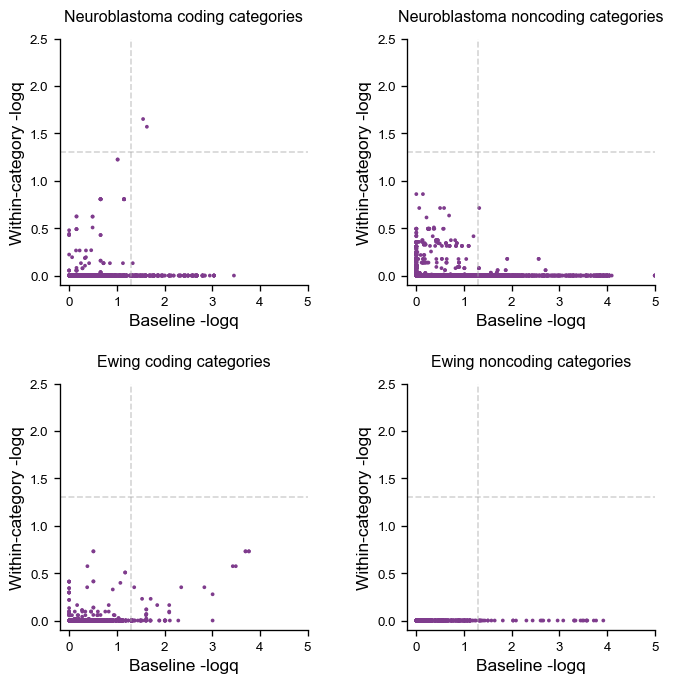

In [66]:
fig, axes = plt.subplots(
    2, 2, figsize=(8, 8), gridspec_kw={"hspace": 0.4, "wspace": 0.4}
)
for i, disease in enumerate(["neuroblastoma", "ewing"]):
    for j, sv_category in enumerate(["coding", "noncoding"]):

        ax = axes[i, j]

        data = stringent_results[
            (stringent_results["disease"] == disease)
            & (stringent_results["sv_category"] == sv_category)
        ].copy()

        data["x"] = -np.log10(data["fdr_p_cases_fisher"])
        data["y"] = -np.log10(data["fdr_p_cases_unique_binom"])

        data = data.dropna(subset=["x", "y"])

        sns.scatterplot(x=data["x"], y=data["y"], ax=ax, s=8, ec=None)

        ax.set_xlim([-0.2, 5])
        ax.set_ylim([-0.1, 2.5])
        ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
        ax.set_xlabel("Baseline -logq")
        ax.set_ylabel("Within-category -logq")
        ax.axvline(x=-np.log10(0.05), color="darkgrey", linestyle="dashed", alpha=0.5)
        ax.axhline(y=-np.log10(0.05), color="darkgrey", linestyle="dashed", alpha=0.5)
        ax.set_title(
            disease.capitalize() + f" {sv_category} categories", fontsize=12, y=1.04
        )

        sns.despine()

fig.savefig(
    f"images/separating-influences-cwas-gene-set-enrichment-coding.png",
    bbox_inches="tight",
)

# Dig into these results

## Neuroblastoma coding

In [102]:
nbl_coding = combined_gse_results.query('disease == "neuroblastoma" & sv_category == "coding" & num_unique_genes_in_overlap_cases_unique_binom > 1 & analysis_fisher == "full"')
nbl_coding = nbl_coding.query('p_controls_binom > 0.05')


posx and posy should be finite values
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/matplotlib/transforms.py:378: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


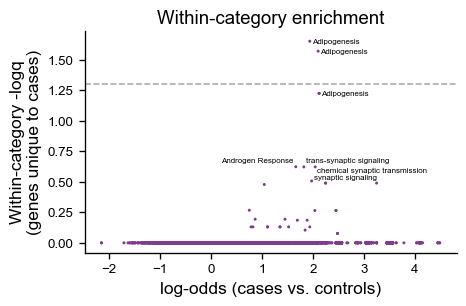

In [150]:
fig, ax = plt.subplots(1, figsize = (5, 3))
    
# first, plot the binomial results
nbl_coding["odds-ratio"] = (
    nbl_coding["observed_prop_cases_binom"] / nbl_coding["observed_prop_controls_binom"]
)

sns.scatterplot(x = np.log2(nbl_coding['odds-ratio']),
                y = -np.log10(nbl_coding['fdr_p_cases_unique_binom']),
                s = 5,
                ec = None)

seen_ps = []
seen_or = []
for i, row in nbl_coding.sort_values(by = 'fdr_p_cases_unique_binom').reset_index().iterrows():

    x = np.log2(row["odds-ratio"])
    y = -np.log10(row["fdr_p_cases_unique_binom"])

    if y in seen_ps and x in seen_or:
        continue
    else:
        s = row["gs"]
        if ' (' in s:
            s = s[:s.index(' (')]
            
        if 'Androgen' in s:
            y += 0.05
            x -= 1.5

        if 'trans' in s:
            if i== 6: y += 0.05
            elif i == 7: y -=0.03
            
        if s == 'synaptic signaling':
            y += 0.03
        
#         if 'mTOR' in s:
#             y -=0.045
            
#         if 'Fatty Acid' in s:
#             x += 1.03
            
        ax.text(x=x + 0.04, y=y, s=s, fontsize=6, ha="left", va="center")
        seen_ps.append(y)
        seen_or.append(x)

    if len(seen_ps) > 7:
        break

ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color='darkgrey')
sns.despine(ax = ax)
ax.set_xlabel('log-odds (cases vs. controls)')
ax.set_ylabel('Within-category -logq\n(genes unique to cases)')
ax.set_title('Within-category enrichment')

fig.savefig('images/nbl-coding-within-category.png', bbox_inches = 'tight')

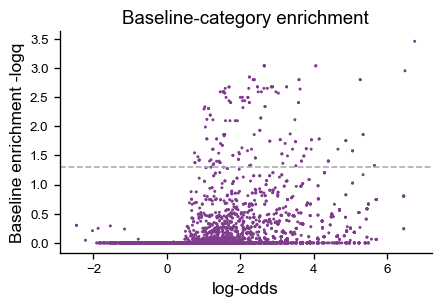

In [104]:
fig, ax = plt.subplots(1, figsize = (5, 3))

sns.scatterplot(x = np.log2(nbl_coding['odds_ratio_cases_fisher']),
                y = -np.log10(nbl_coding['fdr_p_cases_fisher']),
                s = 5,
                ec = None)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color='darkgrey')
sns.despine(ax = ax)
ax.set_xlabel('log-odds')
ax.set_ylabel('Baseline enrichment -logq')
ax.set_title('Baseline-category enrichment')

fig.savefig('images/nbl-coding-baseline-category.png', bbox_inches = 'tight')

What are those two categories that exceed our q cutoff for neuroblastoma?

In [105]:
nbl_coding.query(
    'fdr_p_cases_unique_binom < 0.05'
)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
402679,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,full,MSigDB_Hallmark_2020,Adipogenesis,17/2103,12/368,4.13615,0.00047,0.02342,96/15344,16/2109,1.21421,0.46634,0.56526,3/239,9/217,3.40385,0.07700,1.0,0.01048,0.03261,0.00062,0.03076,11,0.01048,0.00759,0.23765,0.51663,16,0.01048,0.04147,0.00054,0.0269,8,200/19092,200/19092,NaN,1.0,1.0,0.271941,True,ANY,NaN,4.296443
604007,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,16/2037,13/434,3.90039,0.00056,0.02812,92/14893,20/2560,1.26678,0.34732,0.42868,2/199,10/257,3.98785,0.07602,1.0,0.01048,0.02995,0.00082,0.04082,12,0.01048,0.00781,0.20674,0.55087,19,0.01048,0.03891,0.00045,0.0223,9,200/19092,200/19092,NaN,1.0,1.0,0.229244,True,ANY,NaN,3.834827


In [216]:
adipo = gene_sets['GO_Biological_Process_Full | trans-synaptic signaling (GO:0099537)']
test_cat_svs = category_svs[(category_svs['category'] == 'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding') & 
                            (category_svs['disease'] == 'neuroblastoma')]['SV'].tolist()

In [221]:
case_counts = ref_counts.query('disease == "neuroblastoma" & sv_category == "coding" & cohort == "case" & dose > 0')
case_counts[(case_counts['name'].isin(test_cat_svs)) & (case_counts['gene'].isin(adipo))]

,name,dose,gene,disease,sv_category,cohort
39,PedSV.2.5.2_DEL_chr1_833,1,TPRG1L,neuroblastoma,coding,case
2676,PedSV.2.5.2_CPX_chr7_298,1,EXOC4,neuroblastoma,coding,case
2694,PedSV.2.5.2_CPX_chr7_314,1,BRAF,neuroblastoma,coding,case
3623,PedSV.2.5.2_DEL_chr11_520,1,TH,neuroblastoma,coding,case
3663,PedSV.2.5.2_DEL_chr11_1031,1,RIC3,neuroblastoma,coding,case
3813,PedSV.2.5.2_DEL_chr11_5861,1,FCHSD2,neuroblastoma,coding,case
4233,PedSV.2.5.2_CPX_chr12_199,1,P2RX4,neuroblastoma,coding,case
6556,PedSV.2.5.2_INS_chr21_813,1,SYNJ1,neuroblastoma,coding,case
6663,PedSV.2.5.2_DEL_chr22_1874,1,LARGE1,neuroblastoma,coding,case


In [222]:
9/157, 14/864

(0.05732484076433121, 0.016203703703703703)

In [223]:
0.01599 * 9505

151.98495

In [215]:
nbl_coding.sort_values(by = 'fdr_p_cases_unique_binom').head(20)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
604007,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,16/2037,13/434,3.90039,0.00056,0.02812,92/14893,20/2560,1.26678,0.34732,0.42868,2/199,10/257,3.98785,0.07602,1.00000,0.01048,0.02995,0.00082,0.04082,12,0.01048,0.00781,0.20674,0.55087,19,0.01048,0.03891,0.00045,0.02230,9,200/19092,200/19092,NaN,1.000000,1.000000,0.229244,True,ANY,NaN,3.834827
402679,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,17/2103,12/368,4.13615,0.00047,0.02342,96/15344,16/2109,1.21421,0.46634,0.56526,3/239,9/217,3.40385,0.07700,1.00000,0.01048,0.03261,0.00062,0.03076,11,0.01048,0.00759,0.23765,0.51663,16,0.01048,0.04147,0.00054,0.02690,8,200/19092,200/19092,NaN,1.000000,1.000000,0.271941,True,ANY,NaN,4.296443
100687,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,19/2139,10/332,3.46518,0.00314,0.09612,99/15575,13/1878,1.08965,0.75905,0.79068,4/260,8/196,2.72340,0.13763,1.00000,0.01048,0.03012,0.00299,0.14958,9,0.01048,0.00692,0.14064,0.49869,13,0.01048,0.04082,0.00119,0.05964,7,200/19092,200/19092,NaN,1.000000,1.000000,0.275982,True,ANY,NaN,4.352601
805335,neuroblastoma,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,19/2139,10/332,3.46518,0.00314,0.09612,99/15575,13/1878,1.08965,0.75905,0.79068,4/260,8/196,2.72340,0.13763,1.00000,0.01048,0.03012,0.00299,0.14958,9,0.01048,0.00692,0.14064,0.49869,13,0.01048,0.04082,0.00119,0.05964,7,200/19092,200/19092,NaN,1.000000,1.000000,0.275982,True,ANY,NaN,4.352601
251689,neuroblastoma,ANY.SINGLETON.PREDICTED_COPY_GAIN.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Androgen Response,11/2430,2/41,11.27739,0.01867,0.70004,82/17258,3/195,3.27287,0.06980,0.49858,1/429,2/27,34.24000,0.00978,0.16296,0.00524,0.04878,0.01965,0.52849,2,0.00524,0.01538,0.08379,0.83790,2,0.00524,0.07407,0.00883,0.23786,2,100/19092,100/19092,NaN,1.000000,1.000000,0.392649,False,ANY,NaN,3.171651
251749,neuroblastoma,ANY.SINGLETON.PREDICTED_COPY_GAIN.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Pperoxisome,32/2430,2/41,3.84295,0.10804,0.70004,177/17258,0/195,0.00000,0.27237,0.75659,1/429,2/27,34.24000,0.00978,0.16296,0.00545,0.04878,0.02114,0.52849,2,0.00545,0.00000,0.63186,1.00000,0,0.00545,0.07407,0.00951,0.23786,2,104/19092,104/19092,NaN,1.000000,1.000000,0.392649,False,ANY,NaN,inf
379205,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,trans-synaptic signaling (GO:0099537),38/2314,9/157,3.64225,0.00226,0.32203,265/16589,14/864,1.01459,0.88946,1.00000,2/355,9/101,17.26630,0.00004,0.14711,0.01599,0.05732,0.00104,0.62111,9,0.01599,0.01620,0.89196,1.00000,12,0.01599,0.08911,0.00004,0.23860,9,435/19092,152/9505,0.534289,0.000005,0.000125,0.311639

In [162]:
nbl_coding.query('p_cases_unique_binom < 0.05').sort_values(by = 'fdr_p_cases_fisher').head(5)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
371801,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Specific,fatty acid metabolic process (GO:0006631),1/2314,7/157,107.94000,0.0,0.00035,49/16589,6/864,2.36050,0.05356,0.47037,0/355,5/101,inf,0.00049,1.0000,0.00516,0.04459,0.00002,0.05044,6,0.00516,0.00694,0.46708,1.0,6,0.00516,0.04950,0.00019,1.0,4,83/19092,49/9505,1.455960,0.099198,0.633857,0.311639,True,expressed_in_adrenal_gland,NaN,6.425072
573129,neuroblastoma,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Specific,fatty acid metabolic process (GO:0006631),1/2286,7/185,89.85955,0.0,0.00112,46/16388,9/1065,3.02779,0.00570,0.13675,0/334,5/122,inf,0.00129,1.0000,0.00516,0.03784,0.00006,0.11946,6,0.00516,0.00845,0.13079,1.0,8,0.00516,0.04098,0.00046,1.0,4,83/19092,49/9505,1.455960,0.099198,0.633857,0.267334,True,expressed_in_adrenal_gland,NaN,4.478107
4667743,neuroblastoma,DEL.RARE.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,peptidyl-serine phosphorylation (GO:0018105),6/2414,5/57,38.58974,0.0,0.00159,46/17217,10/236,16.51693,0.00000,0.00011,0/429,4/27,inf,0.00001,0.0638,0.02487,0.08772,0.01365,1.00000,4,0.02487,0.04237,0.09109,1.0,5,0.02487,0.14815,0.00425,1.0,3,161/19092,76/3056,4.785930,0.000002,0.000060,0.439906,False,ANY,NaN,2.070333
4718075,neuroblastoma,DEL.RARE.ANY.lof_constrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,peptidyl-serine phosphorylation (GO:0018105),6/2414,5/57,38.58974,0.0,0.00159,46/17217,10/236,16.51693,0.00000,0.00011,0/429,4/27,inf,0.00001,0.0638,0.02487,0.08772,0.01365,1.00000,4,0.02487,0.04237,0.09109,1.0,5,0.02487,0.14815,0.00425,1.0,3,161/19092,76/3056,4.785930,0.000002,0.000060,0.439906,False,ANY,NaN,2.070333
791539,neuroblastoma,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,brain development (GO:0007420),44/2334,17/137,7.37311,0.0,0.00211,252/16689,32/764,2.85142,0.00000,0.00028,14/367,9/89,2.83661,0.02646,1.0000,0.03787,0.12409,0.00002,0.03920,13,0.03787,0.04188,0.56864,1.0,22,0.03787,0.10112,0.00666,1.0,9,720/19092,360/9505,1.008967,0.909321,1.000000,0.282519,False,expressed_in_adrenal_gland,NaN,2.962989


In [194]:
13/421, 20/2560

(0.030878859857482184, 0.0078125)

Our friendly neighborhood adipogenesis gene sets.

Otherwise, it's pretty clear that we'll have to rely on nominal significance. Let's take a look at neuroblastoma first.

In [109]:
neuroblastoma_nominal = nbl_coding.query(
    'fdr_p_cases_fisher < 0.05 & fdr_p_cases_unique_binom < 1'
)
neuroblastoma_nominal

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
402679,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,full,MSigDB_Hallmark_2020,Adipogenesis,17/2103,12/368,4.13615,0.00047,0.02342,96/15344,16/2109,1.21421,0.46634,0.56526,3/239,9/217,3.40385,0.07700,1.00000,0.01048,0.03261,0.00062,0.03076,11,0.01048,0.00759,0.23765,0.51663,16,0.01048,0.04147,0.00054,0.0269,8,200/19092,200/19092,NaN,1.000000,1.000000,0.271941,True,ANY,NaN,4.296443
553675,neuroblastoma,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,full,MSigDB_Hallmark_2020,Adipogenesis,21/2286,8/185,4.87490,0.00093,0.04632,94/16388,18/1065,2.98006,0.00014,0.00090,7/334,5/122,1.99634,0.31820,0.75186,0.01883,0.04324,0.02487,0.53444,8,0.01883,0.01690,0.73535,0.88554,17,0.01883,0.04098,0.08157,0.7402,5,200/19092,179/9505,8.743166,0.000002,0.000005,0.267334,True,expressed_in_adrenal_gland,NaN,2.558580
604007,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,16/2037,13/434,3.90039,0.00056,0.02812,92/14893,20/2560,1.26678,0.34732,0.42868,2/199,10/257,3.98785,0.07602,1.00000,0.01048,0.02995,0.00082,0.04082,12,0.01048,0.00781,0.20674,0.55087,19,0.01048,0.03891,0.00045,0.0223,9,200/19092,200/19092,NaN,1.000000,1.000000,0.229244,True,ANY,NaN,3.834827


## Neuroblastoma non-coding

In [197]:
nbl_noncoding = combined_gse_results.query('disease == "neuroblastoma" & sv_category == "noncoding" & num_unique_genes_in_overlap_cases_unique_binom > 1 & analysis_fisher == "full"')
nbl_noncoding = nbl_noncoding.query('p_controls_binom > 0.05')


Text(0.5, 1.0, 'Within-category enrichment')

posx and posy should be finite values
posx and posy should be finite values
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/matplotlib/transforms.py:378: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


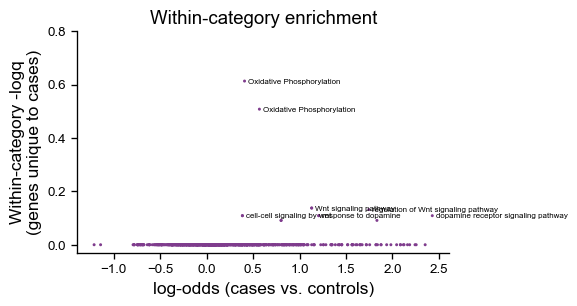

In [203]:
fig, ax = plt.subplots(1, figsize = (5, 3))
    
# first, plot the binomial results
nbl_noncoding["odds-ratio"] = (
    nbl_noncoding["observed_prop_cases_binom"] / nbl_noncoding["observed_prop_controls_binom"]
)

sns.scatterplot(x = np.log2(nbl_noncoding['odds-ratio']),
                y = -np.log10(nbl_noncoding['fdr_p_cases_unique_binom']),
                s = 5,
                ec = None)

seen_ps = []
seen_or = []
for i, row in nbl_noncoding.sort_values(by = 'fdr_p_cases_unique_binom').reset_index().iterrows():

    x = np.log2(row["odds-ratio"])
    y = -np.log10(row["fdr_p_cases_unique_binom"])

    if y in seen_ps and x in seen_or:
        continue
    else:
        s = row["gs"]
        if ' (' in s:
            s = s[:s.index(' (')]
            
        if 'Androgen' in s:
            y += 0.05
            x -= 1.5
            
        ax.text(x=x + 0.04, y=y, s=s, fontsize=6, ha="left", va="center")
        seen_ps.append(y)
        seen_or.append(x)

    if len(seen_ps) > 7:
        break

sns.despine(ax = ax)
ax.set_ylim([None, 0.8])
ax.set_xlabel('log-odds (cases vs. controls)')
ax.set_ylabel('Within-category -logq\n(genes unique to cases)')
ax.set_title('Within-category enrichment')

# fig.savefig('images/nbl-coding-within-category.png', bbox_inches = 'tight')

In [210]:
nbl_noncoding.sort_values(by = 'fdr_p_cases_unique_binom').head(3)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
2566999,neuroblastoma,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak.ANY.ANY.ANY.protein_coding,noncoding,full,MSigDB_Hallmark_2020,Oxidative Phosphorylation,1016/124569,3/183,2.02679,0.18923,0.61115,7831/986086,12/971,1.56314,0.14211,0.27328,2/262,2/8,43.33333,0.00449,0.22445,0.01356,0.01639,0.74127,0.97536,3,0.01356,0.01236,0.88943,0.92649,10,0.01356,0.25000,0.00487,0.24373,2,200/19092,199/14678,60.652462,0.000003,0.000007,0.310309,False,ANY,neuroblastoma_H3K27Ac_peak,1.326052
1761687,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak.ANY.ANY.ANY.protein_coding,noncoding,full,MSigDB_Hallmark_2020,Oxidative Phosphorylation,1014/124496,5/256,2.42584,0.06028,0.42741,7823/985540,20/1517,1.66974,0.02874,0.05988,2/261,2/9,37.00000,0.00574,0.28713,0.01356,0.01953,0.40556,0.88713,5,0.01356,0.01318,1.00000,1.00000,15,0.01356,0.22222,0.00621,0.31055,2,200/19092,199/14678,60.652462,0.000003,0.000007,0.244671,False,ANY,neuroblastoma_H3K27Ac_peak,1.481791
2585701,neuroblastoma,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Specific,proton motive force-driven ATP synthesis (GO:0015986),67/124569,2/183,20.53303,0.00471,1.00000,388/986086,0/971,0.00000,1.00000,1.00000,0/262,2/8,inf,0.00077,1.00000,0.00143,0.01093,0.02873,1.00000,2,0.00143,0.00000,0.65356,1.00000,0,0.00143,0.25000,0.00006,0.71564,2,21/19092,21/14678,inf,0.007341,0.244519,0.310309,False,ANY,neuroblastoma_H3K27Ac_peak,inf


In [212]:
nbl_noncoding[lambda row: row['functional_category'] == 'neuroblastoma_tad_boundary'].sort_values(by = 'fdr_p_cases_unique_binom').head(10)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
1076643,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Specific,regulation of DNA-templated transcription (GO:0006355),4602/124566,12/186,1.79778,0.07491,1.0,36154/986114,25/943,0.71556,0.09960,1.00000,6/260,2/10,10.58333,0.03075,1.0,0.03747,0.06452,0.07683,1.0,12,0.03747,0.02651,0.08550,1.0,19,0.03747,0.200,0.05173,1.0,2,532/19092,124/3309,1.467125,0.000380,0.064468,0.386618,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,2.433799
3360379,neuroblastoma,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of RNA metabolic process (GO:0051252),26063/124533,49/219,1.08900,0.61780,1.0,201991/985997,221/1060,1.02239,0.76076,1.00000,55/262,2/8,1.25455,0.67722,1.0,0.19575,0.22374,0.30655,1.0,48,0.19575,0.20849,0.29603,1.0,177,0.19575,0.250,0.65918,1.0,2,3664/19092,1162/5936,1.036452,0.371676,0.974631,0.400734,True,ANY,neuroblastoma_tad_boundary,1.073145
3360339,neuroblastoma,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of protein metabolic process (GO:0051246),14958/124533,34/219,1.34631,0.11797,1.0,117648/985997,142/1060,1.14171,0.14174,1.00000,28/262,2/8,2.78571,0.21920,1.0,0.12466,0.15525,0.18258,1.0,34,0.12466,0.13396,0.35255,1.0,121,0.12466,0.250,0.26264,1.0,2,2164/19092,740/5936,1.173342,0.001035,0.044641,0.400734,True,ANY,neuroblastoma_tad_boundary,1.158928
3359303,neuroblastoma,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,nucleobase-containing compound metabolic process (GO:0006139),14563/124533,29/219,1.15257,0.46132,1.0,114687/985997,169/1060,1.44101,0.00003,0.01401,38/262,3/8,3.53684,0.10532,1.0,0.16021,0.13242,0.31036,1.0,29,0.16021,0.15943,1.00000,1.0,144,0.16021,0.375,0.12297,1.0,3,2655/19092,951/5936,1.282115,0.000009,0.001439,0.400734,True,ANY,neuroblastoma_tad_boundary,0.830584
3358539,neuroblastoma,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,heterocycle metabolic process (GO:0046483),15717/124533,29/219,1.05674,0.76000,1.0,123859/985997,177/1060,1.39528,0.00010,0.02594,39/262,3/8,3.43077,0.11171,1.0,0.17082,0.13242,0.15033,1.0,29,0.17082,0.16698,0.77516,1.0,152,0.17082,0.375,0.14274,1.0,3,2840/19092,1014/5936,1.278278,0.000010,0.001439,0.400734,True,ANY,neuroblastoma_tad_boundary,0.793029
3357177,neuroblastoma,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of macromolecule metabolic process (GO:0060255),40366/124533,77/219,1.13065,0.38656,1.0,316765/985997,357/1060,1.07288,0.27771,1.00000,

Text(0.5, 1.0, 'Baseline-category enrichment')

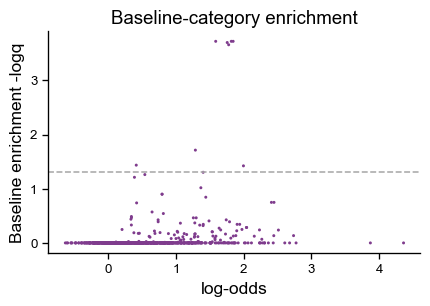

In [204]:
fig, ax = plt.subplots(1, figsize = (5, 3))

sns.scatterplot(x = np.log2(nbl_noncoding['odds_ratio_cases_fisher']),
                y = -np.log10(nbl_noncoding['fdr_p_cases_fisher']),
                s = 5,
                ec = None)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color='darkgrey')
sns.despine(ax = ax)
ax.set_xlabel('log-odds')
ax.set_ylabel('Baseline enrichment -logq')
ax.set_title('Baseline-category enrichment')

# fig.savefig('images/nbl-coding-baseline-category.png', bbox_inches = 'tight')

What are those two categories that exceed our q cutoff for neuroblastoma?

In [205]:
nbl_noncoding.query(
    'fdr_p_cases_fisher < 0.05'
)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
5271155,neuroblastoma,DEL.RARE.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_chromHMM15_EnhG.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,heterocycle metabolic process (GO:0046483),15702/124623,44/129,3.59079,0.00000,0.00019,123921/986454,115/603,1.64025,0.00001,0.00035,40/265,2/5,3.75000,0.17378,1.0,0.21610,0.34109,0.00120,0.08437,15,0.21610,0.19071,0.13770,1.00000,30,0.21610,0.4,0.29598,1.0,2,2840/19092,1619/7492,2.343294,0.000011,0.000300,0.376794,True,ANY,neuroblastoma_chromHMM15_EnhG,1.788527
5271919,neuroblastoma,DEL.RARE.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_chromHMM15_EnhG.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,nucleobase-containing compound metabolic process (GO:0006139),14551/124623,41/129,3.52440,0.00000,0.00019,114748/986454,108/603,1.65746,0.00001,0.00031,39/265,2/5,3.86325,0.16684,1.0,0.20635,0.31783,0.00308,0.19320,14,0.20635,0.17910,0.10718,1.00000,28,0.20635,0.4,0.27578,1.0,2,2655/19092,1546/7492,2.459631,0.000010,0.000284,0.376794,True,ANY,neuroblastoma_chromHMM15_EnhG,1.774595
5281141,neuroblastoma,DEL.RARE.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_chromHMM15_EnhG.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,biosynthetic process (GO:0009058),22275/124623,51/129,3.00426,0.00000,0.00019,175896/986454,147/603,1.48553,0.00006,0.00201,60/265,2/5,2.27778,0.32396,1.0,0.27376,0.39535,0.00290,0.18294,21,0.27376,0.24378,0.10032,1.00000,47,0.27376,0.4,0.61923,1.0,2,3807/19092,2051/7492,2.113168,0.000012,0.000317,0.376794,True,ANY,neuroblastoma_chromHMM15_EnhG,1.621749
5975803,neuroblastoma,DEL.RARE.ANY.neuroblastoma_chromHMM15_EnhG.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,heterocycle metabolic process (GO:0046483),15701/124616,45/136,3.43030,0.00000,0.00022,123899/986363,137/694,1.71214,0.00000,0.00015,40/265,2/5,3.75000,0.17378,1.0,0.21610,0.33088,0.00232,0.15570,16,0.21610,0.19741,0.24889,1.00000,38,0.21610,0.4,0.29598,1.0,2,2840/19092,1619/7492,2.343294,0.000011,0.000300,0.293410,False,ANY,neuroblastoma_chromHMM15_EnhG,1.676106
5976567,neuroblastoma,DEL.RARE.ANY.neuroblastoma_chromHMM15_EnhG.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Full,nucleobase-containing compound metabolic process (GO:0006139),14550/124616,42/136,3.37996,0.00000,0.00020,114726/986363,130/694,1.75121,0.00000,0.00013,39/265,2/5,3.86325,0.16684,1.0,0.20635,0.30882,0.00553,0.32438,15,0.20635,0.18732,0.22291,1.00000,36,0.20635,0.4,0.27578,1.0,2,2655/19092,1546/7492,2.459631,0.000010,0.000284,0.293410,False,ANY,neuroblastoma_chromHMM15_EnhG,1.648623
6109123,neuroblastoma,DEL.RARE.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,noncoding,full,GO_Biological_Process_Specific,Wnt signaling pathway (GO:0016055),1291/123874,22/878,2.44035,0.00030,0.01937,9987/981836,59/5221,1.11224,0.40635,1.00000,1/260,2/10,64.75000,0.00364,1.0,0.01023,0.02506,0.00015,0.01044,8,0.01023,0.01130,0.44860,1.00000,20,0.01023,0.

In [180]:
adipo = gene_sets['MSigDB_Hallmark_2020 | Adipogenesis']
test_cat_svs = category_svs[(category_svs['category'] == 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding') & 
                            (category_svs['disease'] == 'neuroblastoma')]['SV'].tolist()

In [193]:
case_counts = ref_counts.query('disease == "neuroblastoma" & sv_category == "coding" & cohort == "control" & dose > 0')
case_counts[(case_counts['name'].isin(test_cat_svs)) & (case_counts['gene'].isin(adipo))].shape

(20, 6)

In [162]:
nbl_coding.query('p_cases_unique_binom < 0.05').sort_values(by = 'fdr_p_cases_fisher').head(5)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
371801,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Specific,fatty acid metabolic process (GO:0006631),1/2314,7/157,107.94000,0.0,0.00035,49/16589,6/864,2.36050,0.05356,0.47037,0/355,5/101,inf,0.00049,1.0000,0.00516,0.04459,0.00002,0.05044,6,0.00516,0.00694,0.46708,1.0,6,0.00516,0.04950,0.00019,1.0,4,83/19092,49/9505,1.455960,0.099198,0.633857,0.311639,True,expressed_in_adrenal_gland,NaN,6.425072
573129,neuroblastoma,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Specific,fatty acid metabolic process (GO:0006631),1/2286,7/185,89.85955,0.0,0.00112,46/16388,9/1065,3.02779,0.00570,0.13675,0/334,5/122,inf,0.00129,1.0000,0.00516,0.03784,0.00006,0.11946,6,0.00516,0.00845,0.13079,1.0,8,0.00516,0.04098,0.00046,1.0,4,83/19092,49/9505,1.455960,0.099198,0.633857,0.267334,True,expressed_in_adrenal_gland,NaN,4.478107
4667743,neuroblastoma,DEL.RARE.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,peptidyl-serine phosphorylation (GO:0018105),6/2414,5/57,38.58974,0.0,0.00159,46/17217,10/236,16.51693,0.00000,0.00011,0/429,4/27,inf,0.00001,0.0638,0.02487,0.08772,0.01365,1.00000,4,0.02487,0.04237,0.09109,1.0,5,0.02487,0.14815,0.00425,1.0,3,161/19092,76/3056,4.785930,0.000002,0.000060,0.439906,False,ANY,NaN,2.070333
4718075,neuroblastoma,DEL.RARE.ANY.lof_constrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,peptidyl-serine phosphorylation (GO:0018105),6/2414,5/57,38.58974,0.0,0.00159,46/17217,10/236,16.51693,0.00000,0.00011,0/429,4/27,inf,0.00001,0.0638,0.02487,0.08772,0.01365,1.00000,4,0.02487,0.04237,0.09109,1.0,5,0.02487,0.14815,0.00425,1.0,3,161/19092,76/3056,4.785930,0.000002,0.000060,0.439906,False,ANY,NaN,2.070333
791539,neuroblastoma,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,brain development (GO:0007420),44/2334,17/137,7.37311,0.0,0.00211,252/16689,32/764,2.85142,0.00000,0.00028,14/367,9/89,2.83661,0.02646,1.0000,0.03787,0.12409,0.00002,0.03920,13,0.03787,0.04188,0.56864,1.0,22,0.03787,0.10112,0.00666,1.0,9,720/19092,360/9505,1.008967,0.909321,1.000000,0.282519,False,expressed_in_adrenal_gland,NaN,2.962989


In [194]:
13/421, 20/2560

(0.030878859857482184, 0.0078125)

Our friendly neighborhood adipogenesis gene sets.

Otherwise, it's pretty clear that we'll have to rely on nominal significance. Let's take a look at neuroblastoma first.

In [109]:
neuroblastoma_nominal = nbl_coding.query(
    'fdr_p_cases_fisher < 0.05 & fdr_p_cases_unique_binom < 1'
)
neuroblastoma_nominal

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,odds-ratio
402679,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,full,MSigDB_Hallmark_2020,Adipogenesis,17/2103,12/368,4.13615,0.00047,0.02342,96/15344,16/2109,1.21421,0.46634,0.56526,3/239,9/217,3.40385,0.07700,1.00000,0.01048,0.03261,0.00062,0.03076,11,0.01048,0.00759,0.23765,0.51663,16,0.01048,0.04147,0.00054,0.0269,8,200/19092,200/19092,NaN,1.000000,1.000000,0.271941,True,ANY,NaN,4.296443
553675,neuroblastoma,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,full,MSigDB_Hallmark_2020,Adipogenesis,21/2286,8/185,4.87490,0.00093,0.04632,94/16388,18/1065,2.98006,0.00014,0.00090,7/334,5/122,1.99634,0.31820,0.75186,0.01883,0.04324,0.02487,0.53444,8,0.01883,0.01690,0.73535,0.88554,17,0.01883,0.04098,0.08157,0.7402,5,200/19092,179/9505,8.743166,0.000002,0.000005,0.267334,True,expressed_in_adrenal_gland,NaN,2.558580
604007,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,16/2037,13/434,3.90039,0.00056,0.02812,92/14893,20/2560,1.26678,0.34732,0.42868,2/199,10/257,3.98785,0.07602,1.00000,0.01048,0.02995,0.00082,0.04082,12,0.01048,0.00781,0.20674,0.55087,19,0.01048,0.03891,0.00045,0.0223,9,200/19092,200/19092,NaN,1.000000,1.000000,0.229244,True,ANY,NaN,3.834827


## Noncoding

In [177]:
stringent_noncoding_results = combined_gse_results[
    (combined_gse_results["p_controls_binom"] > 0.05)
    & (combined_gse_results["sv_category"] == "noncoding")
][::2]

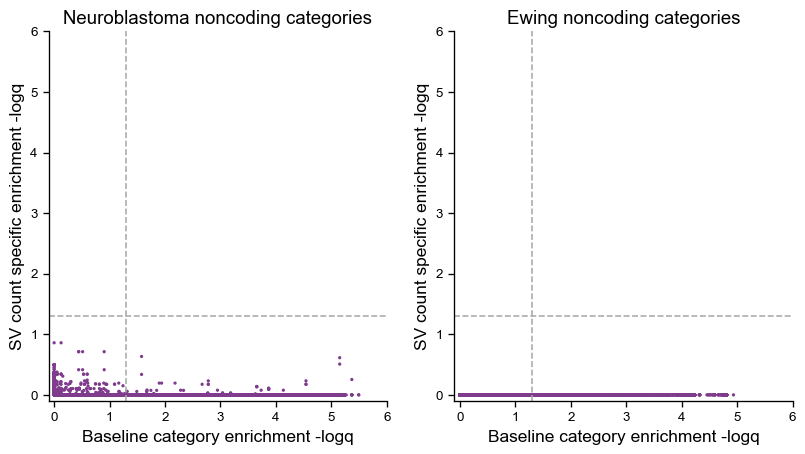

In [178]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, disease in enumerate(["neuroblastoma", "ewing"]):

    ax = axes[i]

    disease_data = stringent_noncoding_results[
        stringent_noncoding_results["disease"] == disease
    ]

    sns.scatterplot(
        x=-np.log10(disease_data["fdr_p_cat_baseline"]),
        y=-np.log10(disease_data["fdr_p_cases_unique_binom"]),
        ax=ax,
        s=6,
        ec=None,
    )

    ax.set_xlim([-0.1, 6])
    ax.set_ylim([-0.1, 6])
    ax.set_xlabel("Baseline category enrichment -logq")
    ax.set_ylabel("SV count specific enrichment -logq")
    ax.axvline(x=-np.log10(0.05), color="darkgrey", linestyle="dashed")
    ax.axhline(y=-np.log10(0.05), color="darkgrey", linestyle="dashed")
    ax.set_title(disease.capitalize() + " noncoding categories")

    sns.despine()

fig.savefig(
    f"images/separating-influences-cwas-gene-set-enrichment-noncoding.png",
    bbox_inches="tight",
)

In [180]:
neuroblastoma_nominal = stringent_noncoding_results.query(
    'fdr_p_cat_baseline < 0.05 & fdr_p_cases_unique_binom < 1 & disease == "neuroblastoma" & db != "Reactome_2022"'
)
neuroblastoma_nominal.sort_values(by="fdr_p_cases_unique_binom")

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,expression,functional_category
7933056,neuroblastoma,ANY.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,noncoding,binary,MSigDB_Hallmark_2020,Myc Targets V1,119/11413,2/20,10.54528,0.01864,0.21504,154/15099,0/46,0.00000,1.00000,1.00000,4/228,1/1,inf,0.02183,0.21834,0.02326,0.07143,0.13759,0.85996,0.02326,0.00000,0.18007,0.96379,0.02326,1.00000,0.02326,0.23256,199/19092,15/645,2.363225,4.236432e-03,0.026478,expressed_in_adrenal_gland,neuroblastoma_tad_boundary_conserved
2752332,neuroblastoma,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak.A...,noncoding,binary,MSigDB_Hallmark_2020,Oxidative Phosphorylation,112/11393,3/178,1.72668,0.26029,0.78773,150/15070,10/808,1.24645,0.46779,0.64109,2/223,2/8,36.83333,0.00610,0.30525,0.01356,0.01639,0.74127,0.97536,0.01356,0.01236,0.88943,0.92649,0.01356,0.25000,0.00487,0.24373,200/19092,199/14678,60.652462,2.684022e-06,0.000007,ANY,neuroblastoma_H3K27Ac_peak
1888876,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak.A...,noncoding,binary,MSigDB_Hallmark_2020,Oxidative Phosphorylation,112/11381,5/245,2.09617,0.10110,0.56167,150/15047,15/1176,1.28312,0.36292,0.56706,2/222,2/9,31.42857,0.00780,0.39014,0.01356,0.01953,0.40556,0.88713,0.01356,0.01318,1.00000,1.00000,0.01356,0.22222,0.00621,0.31055,200/19092,199/14678,60.652462,2.684022e-06,0.000007,ANY,neuroblastoma_H3K27Ac_peak
5936314,neuroblastoma,DEL.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,noncoding,binary,MSigDB_Hallmark_2020,Myc Targets V1,119/11412,2/31,6.54477,0.04224,0.57667,154/15092,2/93,2.13187,0.24769,1.00000,4/227,1/2,55.75000,0.04329,0.43285,0.02326,0.03571,0.37525,1.00000,0.02326,0.00823,0.13685,0.44223,0.02326,0.50000,0.04597,0.45971,199/19092,15/645,2.363225,4.236432e-03,0.026478,expressed_in_adrenal_gland,neuroblastoma_tad_boundary_conserved
2968178,neuroblastoma,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,noncoding,binary,MSigDB_Hallmark_2020,PI3K/AKT/mTOR Signaling,61/11419,1/10,20.68852,0.05296,0.52883,80/15106,2/18,23.47812,0.00420,0.03500,2/228,1/1,inf,0.01310,0.21834,0.03346,0.09091,0.31225,1.00000,0.03346,0.07692,0.21567,0.59907,0.03346,1.00000,0.03346,0.55762,105/19092,18/538,7.347613,2.492176e-07,0.000004,ANY,neuroblastoma_chromHMM15_Enh
2374520,neuroblastoma,DEL.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,noncoding,binary,MSigDB_Hallmark_2020,G2-M Checkpoint,142/11401,3/233,1.03420,0.76738,1.00000,176/15082,10/1108,0.77134,0.55752,0.81988,0/224,1/5,inf,0.02183,0.85058,0.01210,0.01200,1.00000,1.00000,0.01210,0.01120,0.90336,0.92220,0.01210,0.16667,0.07043,0.58693,199/19092,182/15043,2.904658,2.863850e-06,0.000029,ANY,neuroblastoma_chromHMM15_Enh
2374556,neuroblastoma,DEL.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,noncoding,binary,MSigDB_Hallmark_2020,E2F Targets,126/11401,3/233,1.16718,0.74547,1.00000,171/15082,13/1108,1.03524,0.88288,0.95965,3/224,1/5,18.41667,0.08506,0.85058,0.01177,0.01200,0.77113,1.00000,0.01177,0.01541,0.21704,0.38834,0.01177,0.16667,0.06855,0.58693,200/19092,177/15043,2.084131,4.633895e-04,0.001655,ANY,neuroblastoma_chromHMM15_Enh
4317332,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,noncoding,binary,MSigDB_Hallmark_2020,E2F Targets,126/11398,4/224,1.62655,0.32048,0.82414,17

In [181]:
ewing_nominal = stringent_noncoding_results.query(
    'fdr_p_cat_baseline < 0.05 & fdr_p_cases_unique_binom < 1 & disease == "ewing" & db != "Reactome_2022"'
)
ewing_nominal.sort_values(by="fdr_p_cases_unique_binom")

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,expression,functional_category


# Analyze binomial results

Binomial results are perhaps the most interesting of these results.

In [182]:
stringent_coding_results.query('disease == "neuroblastoma"').head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,expression,functional_category
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,6/1015,1/105,1.61699,0.49894,1.0,24/3149,1/540,0.24157,0.16202,0.77074,2/326,1/63,2.6129,0.4123,1.0,0.00557,0.00885,0.46778,1.00000,0.00557,0.00158,0.27748,0.78846,0.00557,0.01538,0.30427,1.0,199/19092,27/4851,0.457816,0.000054,0.000246,ANY,NaN
2,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,Hypoxia,8/1015,1/105,1.21034,0.58906,1.0,25/3149,4/540,0.93254,1.00000,1.00000,2/326,0/63,0.0000,1.0000,1.0,0.00680,0.01770,0.17972,0.87025,0.00680,0.00791,0.62608,0.99680,0.00680,0.00000,1.00000,1.0,200/19092,33/4851,0.577229,0.003174,0.007934,ANY,NaN


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/matplotlib/transforms.py:378: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values
posx and posy should be finite values


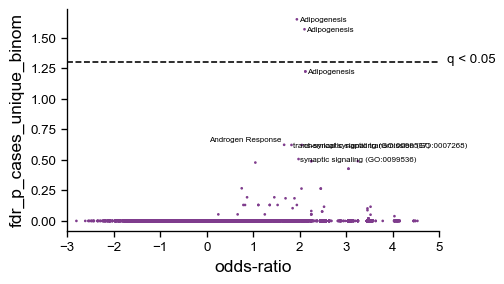

In [201]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = (
    stringent_coding_results.query('disease == "neuroblastoma"')
    .sort_values(by="fdr_p_cases_unique_binom")
    .reset_index()
)

# make an odds ratio relative to controls
data["odds-ratio"] = (
    data["observed_prop_cases_binom"] / data["observed_prop_controls_binom"]
)

sns.scatterplot(
    x=np.log2(data["odds-ratio"]),
    y=-np.log10(data["fdr_p_cases_unique_binom"]),
    ec=None,
    s=4,
)
ax.set_xlim([-3, 5])
sns.despine(ax=ax)
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black")
ax.text(x=1.02, y=0.76, s="q < 0.05", transform=ax.transAxes, fontsize=10)

seen_ps = []
seen_or = []
for i, row in data.iterrows():

    x = np.log2(row["odds-ratio"])
    y = -np.log10(row["fdr_p_cases_unique_binom"])

    if y in seen_ps and x in seen_or:
        continue
    else:
        s = row["gs"]
        if "Androgen" in s:
            y += 0.04
            x -= 1.65
        if "07265" in s:
            y += 0.1
        ax.text(x=x + 0.04, y=y, s=s, fontsize=6, ha="left", va="center")
        seen_ps.append(y)
        seen_or.append(x)

    if len(seen_ps) > 8:
        break

# fig.savefig(
#     "data/cwas-results/single-gene-coding-svs-gene-set-enrichment-plot.png",
#     bbox_inches="tight",
# )

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/matplotlib/transforms.py:378: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


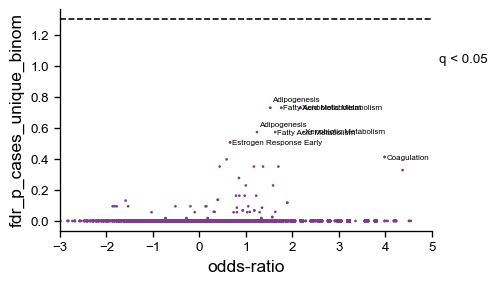

In [203]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = (
    stringent_coding_results.query('disease == "ewing"')
    .sort_values(by="fdr_p_cases_unique_binom")
    .reset_index()
)

# make an odds ratio relative to controls
data["odds-ratio"] = (
    data["observed_prop_cases_binom"] / data["observed_prop_controls_binom"]
)

sns.scatterplot(
    x=np.log2(data["odds-ratio"]),
    y=-np.log10(data["fdr_p_cases_unique_binom"]),
    ec=None,
    s=4,
)
ax.set_xlim([-3, 5])
sns.despine(ax=ax)
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black")
ax.text(x=1.02, y=0.76, s="q < 0.05", transform=ax.transAxes, fontsize=10)

seen_ps = []
seen_or = []
for i, row in data.iterrows():

    x = np.log2(row["odds-ratio"])
    y = -np.log10(row["fdr_p_cases_unique_binom"])

    if y in seen_ps and x in seen_or:
        continue
    else:
        s = row["gs"]
        if "Adipo" in s:
            y += 0.05
        #     y += 0.04
        #     x -=1.65
        # if '07265' in s:
        #     y += 0.1
        ax.text(x=x + 0.04, y=y, s=s, fontsize=6, ha="left", va="center")
        seen_ps.append(y)
        seen_or.append(x)

    if len(seen_ps) > 8:
        break

# fig.savefig(
#     "data/cwas-results/single-gene-coding-svs-gene-set-enrichment-plot.png",
#     bbox_inches="tight",
# )

So some estrogen-related metabolism. Again, there is precedence for the intersection between estrogen metabolism and neuroblastoma:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5819392/

But searching for targeted results here is biased--there will always be associations.

# Dig deeper into specific "hits"

## Adipogenesis

So this shows up in both disease contexts. What's going on here?

In [207]:
stringent_coding_results.query('gs == "Adipogenesis"').head(5)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,expression,functional_category
22,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,binary,MSigDB_Hallmark_2020,Adipogenesis,13/1015,3/105,2.26697,0.18345,0.91969,30/3149,8/540,1.56341,0.25012,0.77074,8/326,2/63,1.30328,0.66805,1.0,0.01175,0.02655,0.14839,0.87025,0.01175,0.01266,0.71289,1.00000,0.01175,0.03077,0.17774,1.00000,200/19092,57/4851,1.172191,0.327109,0.398913,ANY,NaN
53988,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,binary,MSigDB_Hallmark_2020,Adipogenesis,11/987,5/130,3.54909,0.02992,0.37396,27/3006,12/680,1.98204,0.05938,0.21455,7/302,3/88,1.48739,0.70040,1.0,0.01883,0.03650,0.11787,1.00000,0.01883,0.01571,0.68815,0.97410,0.01883,0.03371,0.23565,1.00000,200/19092,179/9505,8.743166,0.000002,0.000005,expressed_in_adrenal_gland,NaN
107976,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,binary,MSigDB_Hallmark_2020,Adipogenesis,7/833,9/309,3.54000,0.01853,0.46315,26/2350,13/1619,0.72354,0.41388,0.98543,3/204,7/190,2.56284,0.20699,1.0,0.01048,0.03012,0.00299,0.14958,0.01048,0.00692,0.14064,0.49869,0.01048,0.04082,0.00119,0.05964,200/19092,200/19092,NaN,1.000000,1.000000,ANY,NaN
107978,ewing,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,binary,MSigDB_Hallmark_2020,Adipogenesis,6/774,9/372,3.17355,0.02776,0.59578,26/2203,11/1499,0.61898,0.23833,0.97207,1/186,7/239,5.58190,0.08481,1.0,0.01048,0.02338,0.02173,0.33939,0.01048,0.00630,0.09831,0.40889,0.01048,0.02869,0.01527,0.76340,200/19092,200/19092,NaN,1.000000,1.000000,ANY,NaN
215886,neuroblastoma,CPX_or_INV.SINGLETON.PREDICTED_COPY_GAIN.ANY.A...,coding,binary,MSigDB_Hallmark_2020,Adipogenesis,16/1106,0/1,0.00000,1.00000,1.00000,36/3526,0/3,0.00000,1.00000,1.00000,10/384,0/1,0.00000,1.00000,1.0,0.01048,0.00000,1.00000,1.00000,0.01048,0.00000,1.00000,1.00000,0.01048,0.00000,1.00000,1.00000,200/19092,200/19092,NaN,1.000000,1.000000,ANY,NaN


That's the same _singleton category_ that is resulting in this signal, in two different contexts. That's kind of... insane, right?

Can we actually check that these are different SVs?

In [218]:
cat = "DEL.SINGLETON.ANY.ANY.ANY.protein_coding"

svs_in_cat = category_svs[category_svs["category"] == cat]["SV"]
print(len(set(svs_in_cat)))

svs_in_cat = sorted(list(svs_in_cat))

3436


So they're the same SVs. But our process used the sample dosages, so if these SVs actually have different dosages, it should work.

In [226]:
genes_affected = ref_counts[
    (ref_counts["name"].isin(svs_in_cat))
    & (ref_counts["cohort"] == "case")
    & (ref_counts["sv_category"] == "coding")
    & (ref_counts["dose"] > 0)
]

genes_affected.head(2)

,name,dose,gene,disease,sv_category,cohort
39,PedSV.2.5.2_DEL_chr1_833,1,TPRG1L,neuroblastoma,coding,case
45,PedSV.2.5.2_DEL_chr1_1140,1,NPHP4,neuroblastoma,coding,case


In [228]:
nbl_genes = genes_affected.query('disease == "neuroblastoma"')
ewing_genes = genes_affected.query('disease == "ewing"')

In [232]:
ewing_genes.shape, nbl_genes.shape, len(
    set(ewing_genes["name"]) & set(nbl_genes["name"])
)

((385, 6), (332, 6), 0)

So there's completely different data here. No SV overlap. What about gene overlap?

In [233]:
adipo_genes = gene_sets["MSigDB_Hallmark_2020 | Adipogenesis"]

In [237]:
ewing_genes[ewing_genes["gene"].isin(adipo_genes)]["gene"].tolist()

['ELMOD3',
 'MYLK',
 'REEP5',
 'CD36',
 'GHITM',
 'CHUK',
 'DHRS7',
 'ACOX1',
 'SAMM50']

In [239]:
nbl_genes[nbl_genes["gene"].isin(adipo_genes)]["gene"].tolist()

['ACADM',
 'MTARC2',
 'SLC66A3',
 'LPL',
 'GPAM',
 'SSPN',
 'SQOR',
 'SQOR',
 'RETN',
 'ITSN1']

Wow, there genes don't even overlap. I feel like that's kind of crazy, right?

I've also checked--these genes are on entirely different chromosomes, so this isn't some genomic region phenomenon.